In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

def load_data(data_dir):
    data = []
    labels = []

    # Read labels from CSV
    labels_df = pd.read_csv('dataset/labels.csv', skiprows=2)

    # Define category directories
    categories = ['numerals', 'vowels', 'consonants']

    # Process each category
    for category in categories:
        category_dir = os.path.join(data_dir, 'nhcd', 'nhcd', category)
        if os.path.exists(category_dir):
            # Process each class directory within the category
            for class_dir in os.listdir(category_dir):
                class_path = os.path.join(category_dir, class_dir)
                if os.path.isdir(class_path):
                    try:
                        class_idx = int(class_dir)  # Convert directory name to class index
                        # Process all images in this class directory
                        for img_name in os.listdir(class_path):
                            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                                img_path = os.path.join(class_path, img_name)
                                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                if img is not None:
                                    img = cv2.resize(img, (32, 32))
                                    data.append(img)
                                    labels.append(class_idx)
                    except ValueError:
                        print(f"Warning: Could not convert directory name to class index: {class_dir}")
                        continue

    if len(data) == 0:
        raise ValueError("No images were loaded. Please check the dataset directory structure and image files.")

    print(f"Loaded {len(data)} images with {len(np.unique(labels))} unique classes")
    return np.array(data), np.array(labels)

def create_model(num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def train_model():
    # Load and preprocess data
    data_dir = 'dataset'
    X, y = load_data(data_dir)
  
    # Get number of unique classes
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")

    # Reshape and normalize data
    X = X.reshape(-1, 32, 32, 1) / 255.0
    y = to_categorical(y, num_classes=num_classes)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and compile model
    model = create_model(num_classes=num_classes)
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint('best_model.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               mode='max',
                               verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train,
                       batch_size=32,
                       epochs=50,
                       validation_data=(X_test, y_test),
                       callbacks=[checkpoint, early_stopping])

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    return model

if __name__ == "__main__":
    model = train_model()

Loaded 12912 images with 37 unique classes
Number of classes: 37


C:\Users\Plan Ghimire\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,358,341 (5.18 MB)

 Trainable params: 1,356,421 (5.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2902 - loss: 2.9678
Epoch 1: val_accuracy improved from -inf to 0.21448, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.2907 - loss: 2.9651 - val_accuracy: 0.2145 - val_loss: 3.4635
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7087 - loss: 0.9635
Epoch 2: val_accuracy improved from 0.21448 to 0.79907, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.7088 - loss: 0.9631 - val_accuracy: 0.7991 - val_loss: 0.6526
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8199 - loss: 0.5562
Epoch 3: val_accuracy improved from 0.79907 to 0.86798, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8199 - loss: 0.5562 - val_accuracy: 0.8680 - val_loss: 0.4119
Epoch 4/50
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8636 - loss: 0.4311
Epoch 4: val_accuracy improved from 0.86798 to 0.91173, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8636 - loss: 0.4311 - val_accuracy: 0.9117 - val_loss: 0.2866
Epoch 5/50
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9057 - loss: 0.3061
Epoch 5: val_accuracy did not improve from 0.91173
323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9056 - loss: 0.3062 - val_accuracy: 0.8997 - val_loss: 0.3394
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9108 - loss: 0.2759
Epoch 6: val_accuracy improved from 0.91173 to 0.93302, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9108 - loss: 0.2759 - val_accuracy: 0.9330 - val_loss: 0.2303
Epoch 7/50
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9290 - loss: 0.2197
Epoch 7: val_accuracy did not improve from 0.93302
323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9290 - loss: 0.2197 - val_accuracy: 0.9322 - val_loss: 0.2275
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9431 - loss: 0.1758
Epoch 8: val_accuracy did not improve from 0.93302
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9431 - loss: 0.1758 - val_accuracy: 0.9288 - val_loss: 0.2625
Epoch 9/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9378 - loss: 0.1954
Epoch 9: val_accuracy did not improve from 0.93302
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9378 - loss: 0.1953 - val_accuracy: 0.9299 - val_loss: 0.2257
Epoch 10/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9537 - loss: 0.1385
Epoch 10: val_accuracy

323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9537 - loss: 0.1385 - val_accuracy: 0.9415 - val_loss: 0.2065
Epoch 11/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9563 - loss: 0.1317
Epoch 11: val_accuracy improved from 0.94154 to 0.94890, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9563 - loss: 0.1317 - val_accuracy: 0.9489 - val_loss: 0.1730
Epoch 12/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9584 - loss: 0.1230
Epoch 12: val_accuracy improved from 0.94890 to 0.95470, saving model to best_model.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9584 - loss: 0.1230 - val_accuracy: 0.9547 - val_loss: 0.1729
Epoch 13/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9616 - loss: 0.1228
Epoch 13: val_accuracy did not improve from 0.95470
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9615 - loss: 0.1228 - val_accuracy: 0.9419 - val_loss: 0.1967
Epoch 14/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9567 - loss: 0.1299
Epoch 14: val_accuracy did not improve from 0.95470
323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9567 - loss: 0.1299 - val_accuracy: 0.9361 - val_loss: 0.2281
Epoch 15/50
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9634 - loss: 0.1130
Epoch 15: val_accuracy did not improve from 0.95470
323/323 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9634 - loss: 0.1130 - val_accuracy: 0.9400 - val_loss: 0.2274
Epoch 16/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9648 - loss: 0.1032
Epoch 16: val_ac

323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9747 - loss: 0.0768 - val_accuracy: 0.9582 - val_loss: 0.1767
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9529 - loss: 0.1747

Test accuracy: 0.9547
Test loss: 0.1729


In [9]:
# Save the trained model and metadata
import os
import numpy as np

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
model_path = 'models/devanagari_model.h5'
model.save(model_path)

# We know there are 37 classes from the training
num_classes = 37  # This is the total number of classes (numerals + vowels + consonants)
class_mapping = {i: str(i) for i in range(num_classes)}

# Save metadata
metadata = {
    'num_classes': num_classes,
    'class_mapping': class_mapping,
    'input_shape': (32, 32, 1)
}
np.save('models/model_metadata.npy', metadata)

print(f"Model saved to {model_path}")
print(f"Metadata saved to models/model_metadata.npy")

Model saved to models/devanagari_model.h5
Metadata saved to models/model_metadata.npy


In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings # Import warnings to suppress the load_model warning

def predict_devanagari_character(image_path, model_path='models/devanagari_model.h5', metadata_path='models/model_metadata.npy'):
    """
    Predict Devanagari character from an image

    Args:
        image_path: Path to the input image
        model_path: Path to the saved model
        metadata_path: Path to the model metadata

    Returns:
        predicted_class: The predicted class index
        confidence: The confidence score for the prediction
    """
    # Load the model and metadata
    # Suppress the warning about compiled metrics not being built
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = load_model(model_path)

    metadata = np.load(metadata_path, allow_pickle=True).item()

    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Resize image to match model's expected input
    img = cv2.resize(img, (32, 32))

    # Normalize and reshape image
    img = img.reshape(1, 32, 32, 1) / 255.0

    # Make prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    return predicted_class, confidence

def get_character_info(class_idx):
    """
    Get information about the predicted character from the labels.csv file

    Args:
        class_idx: The predicted class index

    Returns:
        character_info: Dictionary containing character information, or None if not found
    """
    try:
        # Read the labels file, skipping the initial rows
        labels_df = pd.read_csv('dataset/labels.csv', skiprows=2)

        # Ensure 'Class' column is treated as numeric and drop rows with NaN in 'Class'
        labels_df['Class'] = pd.to_numeric(labels_df['Class'], errors='coerce')
        character_row = labels_df.dropna(subset=['Class'])[labels_df['Class'] == class_idx]

        if not character_row.empty:
            # Extract information from the first matching row
            info = character_row.iloc[0]
            character_info = {
                'type': info.get('Category', 'Unknown Category'), # Use .get for safety
                'label': info.get('Label', 'N/A'),
                'devanagari': info.get('Devanagari Label', 'N/A'),
                'phonetics': info.get('Phonetics', 'N/A')
            }
            return character_info
        else:
            print(f"Debug: No matching class index {class_idx} found in labels.csv")
            return None
    except FileNotFoundError:
        print("Error: labels.csv not found. Make sure it's in the 'dataset' directory.")
        return None
    except Exception as e:
        print(f"An error occurred while reading labels.csv: {e}")
        return None


# Example usage:
def predict_and_display(image_path):
    """
    Predict character and display results with the image

    Args:
        image_path: Path to the input image
    """
    try:
        # Make prediction
        predicted_class, confidence = predict_devanagari_character(image_path)

        # Get character information
        character_info = get_character_info(predicted_class)

        # Display results
        print("\nPrediction Results:")
        print(f"Confidence: {confidence:.2%}")

        devanagari_char = "Unknown"
        if character_info:
            devanagari_char = character_info.get('devanagari', 'Unknown')
            print(f"Type: {character_info.get('type', 'N/A')}")
            print(f"Label: {character_info.get('label', 'N/A')}")
            print(f"Devanagari: {devanagari_char}")
            print(f"Phonetics: {character_info.get('phonetics', 'N/A')}")
        else:
            print(f"Could not find character information for predicted class index {predicted_class}")
            # Fallback to predicted class index if character info is not found
            devanagari_char = f"Class: {predicted_class}"


        # Display the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            plt.figure(figsize=(4, 4))
            plt.imshow(img, cmap='gray')
            # Use the determined Devanagari character (or fallback) for the title
            plt.title(f"Predicted: {devanagari_char}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Could not load image for display: {image_path}")

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except ValueError as ve:
        print(f"Error during prediction: {ve}")
    except Exception as ex:
        print(f"An unexpected error occurred: {ex}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

Prediction Results:
Confidence: 100.00%
Type: Unknown Category
Label: 5
Devanagari: ५
Phonetics: pām̐ca


C:\Users\Plan Ghimire\AppData\Local\Temp\ipykernel_37248\4053660958.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  character_row = labels_df.dropna(subset=['Class'])[labels_df['Class'] == class_idx]
C:\Users\Plan Ghimire\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2411 (\N{DEVANAGARI DIGIT FIVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Plan Ghimire\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


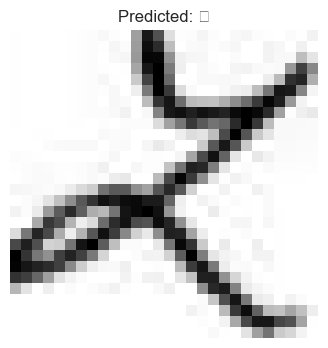

In [30]:
# Example: Test with an image from your dataset
test_image_path = "dataset/nhcd/nhcd/numerals/5/001_01.jpg"  # Replace with an actual image path
predict_and_display(test_image_path)